In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [135]:
unnormalized = pd.read_csv(r'data/final_df.csv')
unnormalized.head()

,sex,gr,Unnamed: 2,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex.1,gr.1,suicide
0,Female,C,766,13.787726,14.778525,14.071394,14.665839,11.264794,13.055630,16.054861,...,11.115703,10.703296,80515,82115,2,c,56,Female,C,Non-Suic
1,Female,C,766,14.045300,15.033390,14.105815,14.796045,11.599565,13.334591,16.357768,...,11.384135,10.716819,80515,83115,4,c,56,Female,C,Non-Suic
2,Female,C,811,13.809070,14.662353,14.213875,14.537931,10.617070,13.053167,15.990168,...,11.009725,10.938700,80515,82115,2,c,72,Female,C,Non-Suic
3,Female,C,811,14.433435,15.185840,14.511720,15.045655,11.579429,13.493932,16.561863,...,11.386591,11.079631,80515,83115,6,c,72,Female,C,Non-Suic
4,Female,C,892,13.372266,14.296781,14.082546,14.174213,10.010893,12.701251,15.542761,...,10.675698,10.809151,80515,82115,2,c,50,Female,C,Non-Suic


In [136]:
def distPlotBetweenGroups(colName, df, ax, legend=False):
    control = df.loc[df['gr']=='C'][colName]
    depression = df.loc[df['gr']=='MDD'][colName]
    treatment = df.loc[df['gr']=='MDD*SSRI'][colName]
    sns.distplot(control, hist=False, ax=ax, label='control')
    sns.distplot(depression, hist=False, ax=ax, label='depression')
    sns.distplot(treatment, hist=False, ax=ax, label='treatment')
    if not legend:
        ax.get_legend().remove()

In [137]:
# fig, ax = plt.subplots(nrows=1, ncols=1)
# distPlotBetweenGroups('1433B_HUMAN', unnormalized, ax)

In [138]:
df = pd.read_excel('data/Report_21_050718_3.xls')

df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

out = out.replace(0, np.nan)

out = out.groupby(['sex','gr']).apply(lambda x: x.fillna(x.mean()))

numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = np.log(numeric_cols)
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

data = out

data = data.drop(['group','gr','sex'], axis=1)

data.suicide.replace(to_replace=['Non-Suic', 'Suicide'], value=[0, 1], inplace=True)
data_y = data['suicide']
data_x = data.drop(['suicide','dt_start','dt_end'], axis = 1)

In [139]:
import warnings
from sklearn.ensemble import RandomForestClassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    forest = RandomForestClassifier(n_estimators=100,max_depth = 5 , class_weight="balanced")
    forest.fit(data_x,data_y)

In [140]:
importances = forest.feature_importances_

In [144]:
indices = np.argsort(importances)[::-1]

df_list = []

for f in range(data_x.shape[1]):
    df_list.append([list(data_x.columns)[indices[f]], importances[indices[f]]])
    
feature_rank = pd.DataFrame(df_list)
feature_rank = feature_rank.rename(columns={0:'feature',1:'importance'})

In [145]:
#Plot the distributions of the different groups to see if there is anything interesting

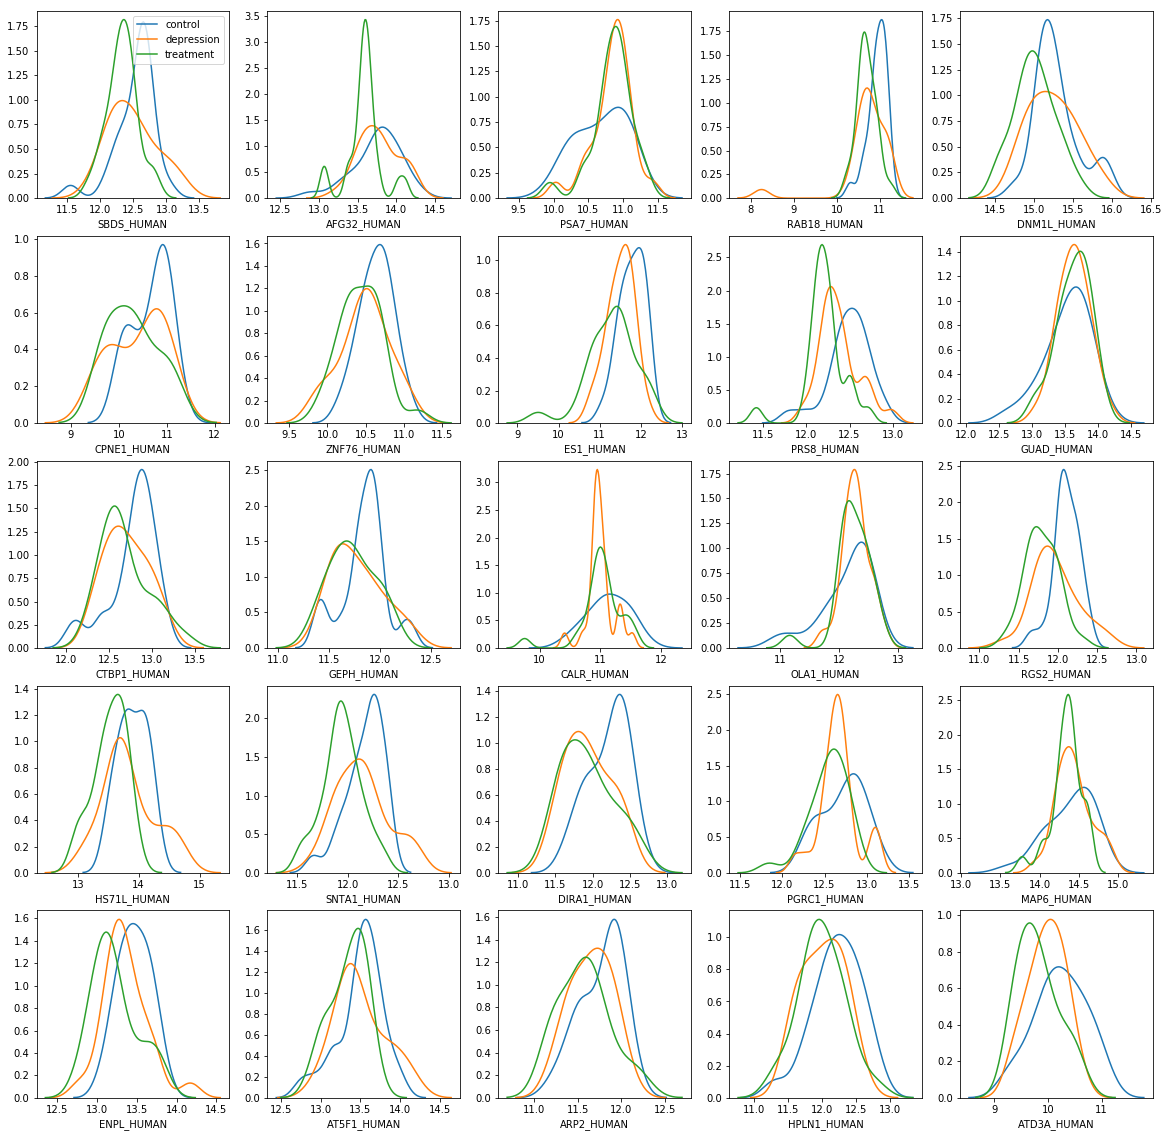

In [146]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
i = 0
for feature in feature_rank['feature']:
    if i < 25:
        r = int(i/5)
        c = i % 5
        legend = False
        if r == 0 and c == 0:
            legend = True
        distPlotBetweenGroups(str(feature), unnormalized, ax[r,c], legend)
    i += 1